In [1]:
# Pairs Trading_Run analysis on a specific pair - 'FTNT', 'PAYX', np.float64(0.0012602955965562773)
"""
Hedge ratio estimation - OLS

Spread construction

Identify Entry/Exit Signals - Mean-reversion Z-score strategy

Backtest + plot

Backtest the Strategy
"""
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
pairs = ['FTNT','PAYX']
start_date = '2020-01-01'
end_date = '2025-10-01'
df = yf.download(pairs, start_date, end_date, auto_adjust=True)['Close']

[*********************100%***********************]  2 of 2 completed


Hedge Ration =  1.6870535858095552


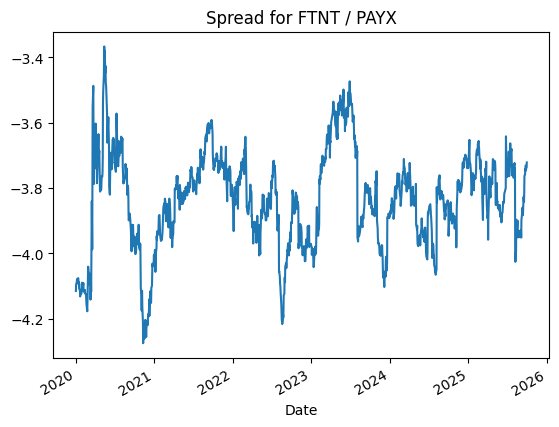

In [3]:
# Compute hedge ratio (OLS)

df = df.dropna(axis=1).ffill()

log_prices = np.log(df)
s1, s2 = log_prices

X = sm.add_constant(log_prices[s2])
model = sm.OLS(log_prices[s1], X).fit()
hedge_ratio = model.params.iloc[1]

print("Hedge Ration = ", hedge_ratio)

spread = log_prices[s1] - hedge_ratio * log_prices[s2]
spread.plot(title=f"Spread for {s1} / {s2}")
plt.show()

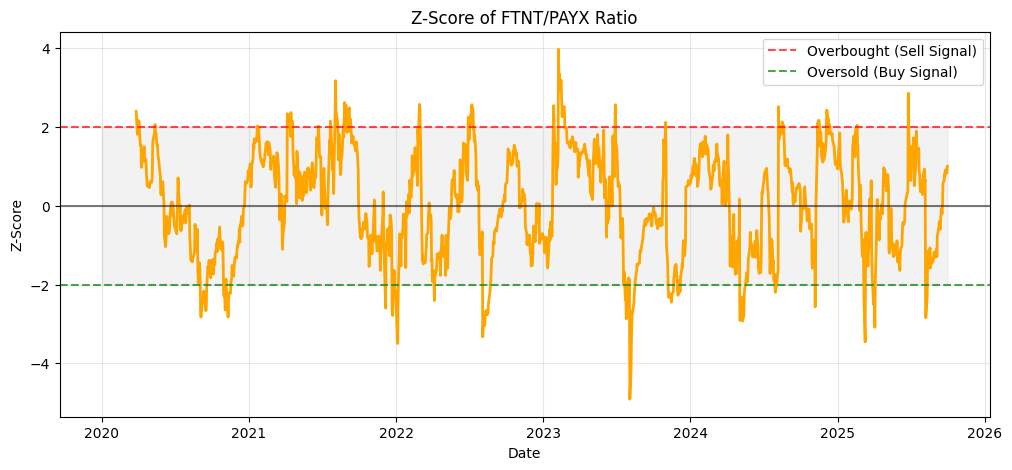

In [4]:
# Simple Z-Score StrategyEnter long/short based on 2σ deviations and exit at 0σ.
# compute z-score
mean = spread.rolling(window=60).mean()
std = spread.rolling(window=60).std()
zscore = (spread - mean) / std

plt.figure(figsize=(12,5))
plt.plot(zscore, color='orange', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Overbought (Sell Signal)')
plt.axhline(y=-2, color='green', linestyle='--', alpha=0.7, label='Oversold (Buy Signal)')
plt.fill_between(log_prices.index, 2, -2, alpha=0.1, color='gray')
plt.title(f'Z-Score of {s1}/{s2} Ratio')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
# simple trading rules 
"""
1. When z-score < -2 (ratio is too low):
   - BUY Stock 1 
   - SELL Stock 2 
   (Expect ratio to go back up to average)

2. When z-score > 2 (ratio is too high):
   - SELL Stock 1 
   - BUY Stock 2 
   (Expect ratio to go back down to average)

3. Exit position when z-score crosses 0
"""
long_signal  = zscore < -2
short_signal = zscore >  2
exit_signal  = (abs(zscore) < 0.5)

# positions
positions = pd.DataFrame(index=log_prices.index, columns=["s1", "s2"])
positions["s1"] = 0.0
positions["s2"] = 0.0

# long spread = buy s1, sell s2
positions.loc[long_signal, "s1"] = 1
positions.loc[long_signal, "s2"] = -hedge_ratio

# short spread = sell s1, buy s2
positions.loc[short_signal, "s1"] = -1
positions.loc[short_signal, "s2"] = hedge_ratio

# exit = 0
positions.loc[exit_signal, :] = 0

positions = positions.shift(1).fillna(0)  # enter next day


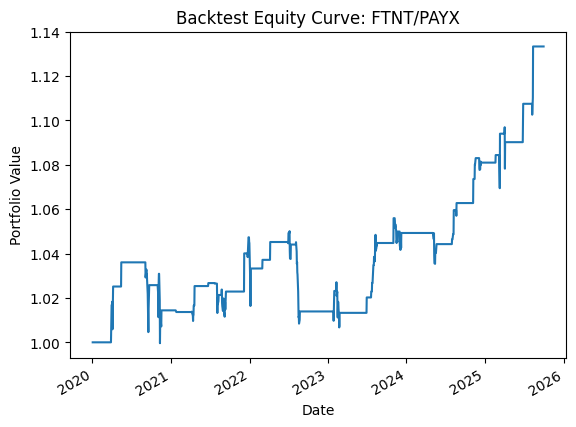

Date
2025-09-24    1.133372
2025-09-25    1.133372
2025-09-26    1.133372
2025-09-29    1.133372
2025-09-30    1.133372
dtype: float64

In [7]:
#Compute Backtest PnL

returns = log_prices.pct_change().fillna(0)

pnl = (positions["s1"] * returns[s1] + positions["s2"] * returns[s2])
equity_curve = (1 + pnl).cumprod()

equity_curve.plot(title=f"Backtest Equity Curve: {s1}/{s2}")
plt.ylabel("Portfolio Value")
plt.show()

equity_curve.tail()